<a href="https://colab.research.google.com/github/soayeb95/assignment_04/blob/master/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from PIL import Image
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%config InlineBackend.figure_formats = ['svg']

import os
from torchvision.io import read_image, ImageReadMode
import torch
import torchvision.transforms.functional as F
import torchvision.transforms as newF
from torch.utils.data import Dataset,random_split
from torchvision.utils import make_grid
from torchvision import datasets
import torchvision.transforms as tr
from pathlib import Path

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torchvision

# Create DataSet class
We could use one of the base `DataSet` classes mentioned in the [docs](http://pytorch.org/vision/main/datasets.html#base-classes-for-custom-datasets) but I prefer writing my own to be more flexible. 

In [2]:
class BrainDataset(Dataset):
    
    def __init__(self, base_dir, transforms = None):
        """
        Arguments:
            transforms: iterable
                Collection of transforms to apply when loading an image
        """
        
        self.base_dir = Path(base_dir)
        self.transforms = transforms
        
        self.data_dicts = []
        for img in self.base_dir.glob("*oma*/*.jp*g"):
            # Get all images of sick patients, every tumor name contains "oma" 
            img_dict = {}
            img_dict["img_path"] = img
            img_dict["label"],img_dict["img_type"] = img.parent.name.split(" ")
            self.data_dicts.append(img_dict)
            
        for img in self.base_dir.glob("*NORMAL*/*.jp*g"):
            # Get all images of normal patients    
            img_dict = {}
            img_dict["img_path"] = img
            img_dict["label"],img_dict["img_type"] = "Normal", img.parent.name.split(" ")[1]
            self.data_dicts.append(img_dict)
        
        self.data = pd.DataFrame(self.data_dicts)
        self.labels = self.data["label"]
        
        self.encoder = LabelEncoder()
        self.y = self.encoder.fit_transform(self.labels)
        self.num_classes = len(self.encoder.classes_)
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        image = read_image(str(self.data.loc[idx,"img_path"]),mode=ImageReadMode.RGB) # read image into a Tensor
        # image = Image.open(self.data.loc[idx,"img_path"]).convert("RGB") # read image into a PIL Image
       

        #image = torchvision.transforms.functional.to_tensor(self.data.iloc[idx, 1:-1].values.astype(np.uint8).reshape((1, 16, 16)))



        label = self.y[idx]
        
        if self.transforms is not None:
            return self.transforms(image), label
        else:
            return image, label
    
    
    def display(self,idxs):
        """
        Display a few images from the dataset.
        
        """
        
        img_list = [F.to_pil_image(self[idx][0]) for idx in idxs]
            
        labels = [self.labels[idx] for idx in idxs]
        
        fig,axs = plt.subplots(ncols=len(idxs),nrows=1,squeeze=False,figsize=(10,len(idxs)*16))
        
        for i,ax in enumerate(axs.flat):
            ax.imshow(img_list[i],cmap='gray')
            ax.set_title(labels[i],size=8)
            ax.grid()
            ax.axis('off')
            
        return fig,axs
    
    def _ipython_display_(self):
        # Render the underlying DataFrame when asked to display self in a notebook
        display(self.data)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
base_dir = Path('drive/MyDrive/44_class')

Mounted at /content/drive/


# Load Dataset

In [4]:
brain_data = BrainDataset(base_dir,transforms=tr.Resize(size=224))

In [5]:
len(brain_data)

4465

In [6]:
brain_data

,img_path,label,img_type
0,drive/MyDrive/44_class/Schwannoma T2/8_big_gal...,Schwannoma,T2
1,drive/MyDrive/44_class/Schwannoma T2/814f73048...,Schwannoma,T2
2,drive/MyDrive/44_class/Schwannoma T2/975009625...,Schwannoma,T2
3,drive/MyDrive/44_class/Schwannoma T2/ea957839a...,Schwannoma,T2
4,drive/MyDrive/44_class/Schwannoma T2/147a0d254...,Schwannoma,T2
...,...,...,...
4460,drive/MyDrive/44_class/_NORMAL T1/2022-06-13 0...,Normal,T1
4461,drive/MyDrive/44_class/_NORMAL T1/a5e1e3151740...,Normal,T1
4462,drive/MyDrive/44_class/_NORMAL T1/2022-06-13 0...,Normal,T1
4463,drive/MyDrive/44_class/_NORMAL T1/2022-06-13 0...,Normal,T1


The images are all in grayscale, reasonably centered with a black frame around them.

In [7]:
brain_data.data['img_type'].nunique()

3

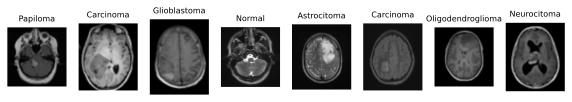

In [8]:
idxs = np.random.choice(len(brain_data),size=8)
brain_data.display(idxs);

In [9]:
brain_data.data.describe()

,img_path,label,img_type
count,4465,4465,4465
unique,4465,15,3
top,drive/MyDrive/44_class/Schwannoma T2/8_big_gal...,Meningioma,T1C+
freq,1,874,1686


HIstogram to know about data

In [10]:
px.histogram(brain_data.data,x="label")

# Autocropping


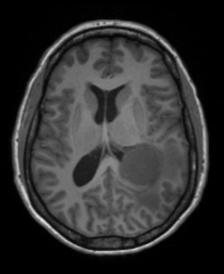

In [11]:
img = F.to_pil_image(brain_data[2000][0])
img

detecting edge detecor

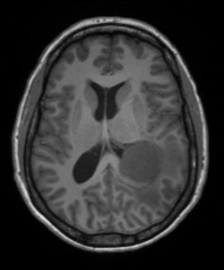

In [12]:
img.crop(img.getbbox())

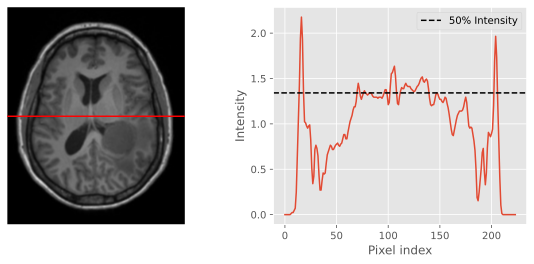

In [13]:
imgT = tr.ToTensor()(img)[:,:,]
C,H,W = imgT.shape

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].imshow(img)
ax[0].axhline(H//2,color="red")
ax[0].grid()
ax[0].axis("off");

ax[1].plot(torch.sum(imgT[:,H//2,:],axis=0))
ax[1].set_xlabel("Pixel index")
ax[1].set_ylabel("Intensity")
ax[1].axhline(0.5*torch.max(torch.sum(imgT,axis=0)),color="Black",label="50% Intensity",linestyle="--")
ax[1].legend();
# plt.plot(torch.sum(imgT[:,:,W//2],axis=0))

In [14]:
import torchvision.transforms.functional as F
# custom transform inherit from nn.Module and give it a forward method
class CropToContent(torch.nn.Module):

    def __init__(self,threshold=0.1,ignore_frame_pixels=5):
        super().__init__()
        self.threshold = threshold
        self.ignore_frame_pixels = ignore_frame_pixels if ignore_frame_pixels > 0 else None

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be cropped.
        Returns:
            Tensor: Cropped image.
        """
            
        C,H,W = img.shape
        skipH = self.ignore_frame_pixels
        skipT = -self.ignore_frame_pixels if self.ignore_frame_pixels is not None else None
        
        ymax = torch.max(torch.sum(img[:,H//2,skipH:skipT],axis=0))
        xmax = torch.max(torch.sum(img[:,skipH:skipT,W//2],axis=0))
           
        bottom, top = torch.nonzero(torch.sum(img[:,H//2,skipH:skipT],axis=0) > self.threshold*ymax)[[0,-1]]
        left, right = torch.nonzero(torch.sum(img[:,skipH:skipT,W//2],axis=0) > self.threshold*xmax)[[0,-1]]
        
        return F.center_crop(img,output_size=[(right-left).item(),(top-bottom).item()])
    
    def __repr__(self):
        return f"CropToContent(threshold={self.threshold})"

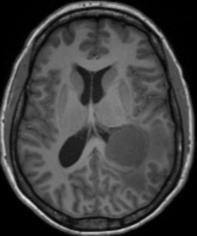

In [15]:
import torchvision.transforms.functional as F
F.to_pil_image(CropToContent(threshold=0.1,ignore_frame_pixels=1)(F.to_tensor(img)))

resizing the images to $224\times224$ 

In [16]:
 brain_data = BrainDataset(base_dir,transforms=tr.Compose([
     tr.Resize([224,224]),
     ]
     ))

In [17]:

import torchvision.transforms.functional as F
brain_data = BrainDataset(base_dir,transforms=tr.Compose([
    CropToContent(threshold=0.1,ignore_frame_pixels=5),
    tr.Resize([224,224]),
    ]
    ))

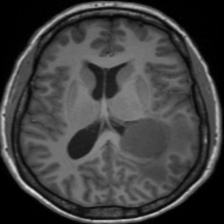

In [18]:
F.to_pil_image(brain_data[135][0])

This transformation distorts the image, but the tumor is still clearly recognizable so I do not expect to degrade performance too much.

In [19]:
#Unet

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [20]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, 64))
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(802816, 128) # RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x802816 and 16384x128) 32x802816 and 16384x128
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, n_classes)
        print(n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        out = self.max_pool2(x)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        logits = self.fc2(out)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
        self.fc1 = torch.utils.checkpoint(self.fc1)
        self.fc2 = torch.utils.checkpoint(self.fc2)
   
    def training_step(self,batch,batch_idx):
        logits = self(batch[0])
        preds = torch.argmax(model(batch[0]),axis=1)
        
        loss = torch.nn.functional.cross_entropy(logits,batch[1])
        acc = accuracy(preds,batch[1],task="multiclass",num_classes=brain_data.num_classes) 
        
        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return loss
    
    def validation_step(self,batch,batch_idx):
        logits = self(batch[0])
        preds = torch.argmax(model(batch[0]),axis=1)
        
        loss = torch.nn.functional.cross_entropy(logits,batch[1])
        acc = accuracy(preds,batch[1],task="multiclass",num_classes=brain_data.num_classes) 
        
        self.log('valid_loss', loss)
        self.log('valid_acc', acc)
        
        return loss
    
    def test_step(self,batch,batch_idx):
        logits = self(batch[0])
        preds = torch.argmax(model(batch[0]),axis=1)
        
        loss = torch.nn.functional.cross_entropy(logits,batch[1])
        acc = accuracy(preds,batch[1],task="multiclass",num_classes=brain_data.num_classes) 
        
        self.log('valid_loss', loss)
        self.log('valid_acc', acc)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adadelta(self.parameters())

# Splitting the data


In [21]:
val_set_size = 893
train_set, valid_set = random_split(brain_data,[len(brain_data)-val_set_size,val_set_size])

It looks like the `Subset` class does not inherit from the custom class we wrote, so it does not have the `display` method.

In [22]:
from torch.utils.data import DataLoader

In [23]:
train_loader = DataLoader(train_set,batch_size=32,shuffle=True,num_workers=4)
valid_loader = DataLoader(valid_set,batch_size=32,shuffle=False,num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



# Augmentations


In [24]:
n_channels= 3
n_classes = 44
model = UNet(n_channels,n_classes, False)

44


In [25]:
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 20

n_channels= 3
n_classes = 44
model = UNet(n_channels,n_classes, False)
model.cuda()
#model = model.to(device)
#device = torch.device("cuda")
#model.cuda()
# Set Loss function with criterion
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)
criterion = nn.CrossEntropyLoss()


# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

44


In [26]:
from torch import Tensor

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [27]:
import torchvision.transforms.functional as F
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        # images = images.to(device)
        # labels = labels.to(device)
        images, labels = images.cuda(), labels.cuda()

        # Forward pass
        # outputs = model(images)
        # loss = criterion(outputs, labels)
        masks_pred = model(images.float())
        loss = criterion(masks_pred, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

            
            


Epoch [1/20], Loss: 0.7730
Epoch [2/20], Loss: 0.1078
Epoch [3/20], Loss: 0.0166
Epoch [4/20], Loss: 0.0054
Epoch [5/20], Loss: 0.0028
Epoch [6/20], Loss: 0.0023
Epoch [7/20], Loss: 0.0049
Epoch [8/20], Loss: 0.0054
Epoch [9/20], Loss: 0.0022
Epoch [10/20], Loss: 0.0024
Epoch [11/20], Loss: 0.0031
Epoch [12/20], Loss: 0.0033
Epoch [13/20], Loss: 0.0043
Epoch [14/20], Loss: 0.0037
Epoch [15/20], Loss: 0.0017
Epoch [16/20], Loss: 0.0019
Epoch [17/20], Loss: 0.0013
Epoch [18/20], Loss: 0.0013
Epoch [19/20], Loss: 0.0022
Epoch [20/20], Loss: 0.0054


I trained the model on a single GPU and saved its parameters. Let's load it and measure its accuracy on the validation set

In [32]:
epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"



In [29]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        # images = images.to(device)
        # labels = labels.to(device)
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} test images: {} %'.format( 4465, 100 * correct / total))

Accuracy of the network on the 4465 test images: 91.71332586786114 %


In [30]:
model.eval()

predictions = []
truth = []

with torch.inference_mode():
    
    for data,true_labels in valid_loader:
        pred_labels = torch.argmax(model(data),axis=1)
        
        predictions.append(pred_labels)
        truth.append(true_labels)

RuntimeError: ignored

In [ ]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

print(classification_report(torch.cat(truth),torch.cat(predictions),target_names=brain_data.encoder.classes_))

ConfusionMatrixDisplay.from_predictions(torch.cat(truth),torch.cat(predictions),display_labels=brain_data.encoder.classes_,xticks_rotation='vertical',cmap='Blues')
plt.grid(visible=False)

Despite some classes having very few examples (~10), the F1 score is still 0.99, which is excellent.

In [31]:
model.eval()

with torch.inference_mode():
    for data,label in valid_loader:
        pred_labels = torch.argmax(model(data),axis=1)
        
        idxs = torch.nonzero(pred_labels != label).T[0]
        
        for i in idxs:
            plt.figure()
            img = data[i]
            plt.imshow(F.to_pil_image(img))
            true = brain_data.encoder.classes_[label[i]]
            pred = brain_data.encoder.classes_[pred_labels[i]]
            plt.axis("off")
            plt.grid()
            plt.title(f"True: {true} Pred: {pred}")

RuntimeError: ignored